Test the performence of deep-ae

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [29]:
import numpy as np
import pandas as pd

import pickle
import matplotlib.pyplot as plt
%matplotlib inline

from keras.layers import Input, Dense
from keras.models import Model
import keras
import keras.backend as K

from sklearn import preprocessing
import seaborn as sns

Globals

In [4]:
early_stopping_monitor = keras.callbacks.EarlyStopping(monitor='loss', patience=50, verbose=1)

Load data

In [4]:
pklfile = '../data/sob_genes.pkl'
with open(pklfile, 'rb') as fi:
    data = pickle.load(fi)
    
pklfile = '../data/sob_genes_03.pkl'
with open(pklfile, 'rb') as fi:
    data03 = pickle.load(fi)
    

Scaling data to [0,1]

In [5]:
data = preprocessing.MinMaxScaler().fit_transform(np.abs(data))
data03 = preprocessing.MinMaxScaler().fit_transform(np.abs(data03))

### Models

Basic Denoising Autoencoder

In [5]:
def basic_dae(feat_mat, noise_factor=0.05, hidden_size=800, batch_size=128, epochs=2000):
    
    input_size = feat_mat.shape[1]
    feat_noisy = feat_mat + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=feat_mat.shape) 
    feat_noisy = np.clip(feat_noisy, 0., 1.)

    x = Input(shape=(input_size,))
    h = Dense(hidden_size, activation='relu')(x)
    r = Dense(input_size, activation='sigmoid')(h)

    dae = Model(inputs=x, outputs=r)
    dae.compile(optimizer='adam', loss='mse',metrics=['accuracy'])

    history_base = dae.fit(feat_noisy, feat_noisy, batch_size=batch_size,epochs=epochs, callbacks = [early_stopping_monitor])
    encoder = Model(x,h)
    return dae, encoder

Basic Autoencoder

In [19]:
def basic_ae(feat_mat, hidden_size=800, batch_size=128, epochs=2000):

    input_size = feat_mat.shape[1]
    x = Input(shape=(input_size,))
    h = Dense(hidden_size, activation='relu')(x)
    r = Dense(input_size, activation='sigmoid')(h)

    dae = Model(inputs=x, outputs=r)
    dae.compile(optimizer='adam', loss='mse',metrics=['accuracy'])

    history_base = dae.fit(feat_mat, feat_mat, batch_size=batch_size,epochs=epochs, callbacks = [early_stopping_monitor])
    encoder = Model(x,h)
    return dae, encoder

Contractive Autoencoder

In [51]:
def cae(feat_mat, hidden_size=800, lam=1e-5, batch_size=128, epochs=2000):

    input_size = feat_mat.shape[1]
    x = Input(shape=(input_size,))
    h = Dense(hidden_size, activation='relu', name='encoded')(x)
    r = Dense(input_size, activation='sigmoid')(h)

    ae= Model(inputs=x, outputs=r)

    def contractive_loss(y_pred, y_true):
        mse = K.mean(K.square(y_true - y_pred), axis=1)

        W = K.variable(value=ae.get_layer('encoded').get_weights()[0])  # N x N_hidden
        W = K.transpose(W)  # N_hidden x N
        h = ae.get_layer('encoded').output
        dh = h * (1 - h)  # N_batch x N_hidden

        # N_batch x N_hidden * N_hidden x 1 = N_batch x 1
        contractive = lam * K.sum(dh**2 * K.sum(W**2, axis=1), axis=1)

        return mse + contractive


    ae.compile(optimizer='adam', loss=contractive_loss, metrics=['accuracy'])
    history = ae.fit(feat_mat, feat_mat, batch_size=batch_size,epochs=epochs, callbacks = [early_stopping_monitor])  
    encoder = Model(x, h)
    

    return ae, encoder

In [7]:
models = []
encoders = []
core_list = [2**i for i in range(8,14)]


In [10]:
dae, encoder = basic_dae(data, hidden_size=4000)

Epoch 1/2000
9636/9636 [==============================] - 36s 4ms/step - loss: 0.0164 - acc: 2.0756e-04
Epoch 2/2000
9636/9636 [==============================] - 24s 3ms/step - loss: 0.0086 - acc: 2.0756e-04
Epoch 3/2000
9636/9636 [==============================] - 24s 3ms/step - loss: 0.0086 - acc: 2.0756e-04
Epoch 4/2000
9636/9636 [==============================] - 25s 3ms/step - loss: 0.0086 - acc: 2.0756e-04
Epoch 5/2000
9636/9636 [==============================] - 24s 3ms/step - loss: 0.0086 - acc: 2.0756e-04
Epoch 6/2000
9636/9636 [==============================] - 25s 3ms/step - loss: 0.0086 - acc: 2.0756e-04
Epoch 7/2000
1536/9636 [===>..........................] - ETA: 20s - loss: 0.0086 - acc: 6.5104e-04

KeyboardInterrupt: 

In [12]:
dae1, encoder1 = basic_dae(data03, hidden_size=8000)

Epoch 1/2000
9636/9636 [==============================] - 14s 1ms/step - loss: 0.0505 - acc: 3.1133e-04
Epoch 2/2000
9636/9636 [==============================] - 9s 946us/step - loss: 0.0479 - acc: 2.0756e-04
Epoch 3/2000
9636/9636 [==============================] - 9s 949us/step - loss: 0.0490 - acc: 2.0756e-04
Epoch 4/2000
9636/9636 [==============================] - 9s 947us/step - loss: 0.0498 - acc: 3.1133e-04
Epoch 5/2000
9636/9636 [==============================] - 9s 949us/step - loss: 0.0509 - acc: 0.0000e+00
Epoch 6/2000
9636/9636 [==============================] - 9s 948us/step - loss: 0.0517 - acc: 2.0756e-04
Epoch 7/2000
9636/9636 [==============================] - 9s 951us/step - loss: 0.0524 - acc: 4.1511e-04
Epoch 8/2000
9636/9636 [==============================] - 9s 952us/step - loss: 0.0531 - acc: 6.2267e-04
Epoch 9/2000
9636/9636 [==============================] - 9s 949us/step - loss: 0.0540 - acc: 6.2267e-04
Epoch 10/2000
9636/9636 [==============================]

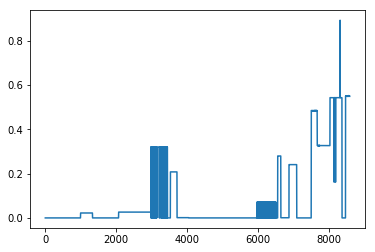

In [15]:
sns.lineplot(x=range(data03.shape[1]),y=np.abs(data03[2222]))

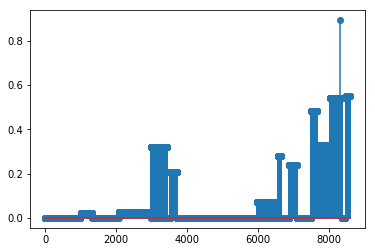

In [21]:
plt.stem(np.abs(data03[2222]))
plt.show()

In [20]:
import matplotlib
matplotlib.__version__

'3.0.3'

### Gene_0406 dataset

In [6]:
pklfile = '../data/sob_genes_0406.pkl'
with open(pklfile, 'rb') as fi:
    data0406 = pickle.load(fi)

In [7]:
data0406 = preprocessing.MinMaxScaler().fit_transform(np.abs(data0406))

In [8]:
data0406.shape

(9636, 2053)

In [9]:
dae, encoder = basic_dae(data0406, hidden_size=1500)







Epoch 1/2000
9636/9636 [==============================] - 5s 558us/step - loss: 0.0706 - acc: 0.0074
Epoch 2/2000
9636/9636 [==============================] - 1s 60us/step - loss: 0.0617 - acc: 0.0119
Epoch 3/2000
9636/9636 [==============================] - 1s 60us/step - loss: 0.0603 - acc: 0.0148
Epoch 4/2000
9636/9636 [==============================] - 1s 60us/step - loss: 0.0575 - acc: 0.0140
Epoch 5/2000
9636/9636 [==============================] - 1s 60us/step - loss: 0.0375 - acc: 0.0167
Epoch 6/2000
9636/9636 [==============================] - 1s 60us/step - loss: 0.0118 - acc: 0.0253
Epoch 7/2000
9636/9636 [==============================] - 1s 60us/step - loss: 0.0069 - acc: 0.0314
Epoch 8/2000
9636/9636 [==============================] - 1s 60us/step - loss: 0.0056 - acc: 0.0318
Epoch 9/2000
9636/9636 [==============================] - 1s 61us/step - loss: 0.0050 - acc: 0.0356
Epoch 10/2000
9636/9636 [==============================] - 1s 61us/step - loss: 0.0051 - acc:

9636/9636 [==============================] - 1s 61us/step - loss: 0.0016 - acc: 0.1776
Epoch 150/2000
9636/9636 [==============================] - 1s 61us/step - loss: 0.0016 - acc: 0.1762
Epoch 151/2000
9636/9636 [==============================] - 1s 61us/step - loss: 0.0017 - acc: 0.1762
Epoch 152/2000
9636/9636 [==============================] - 1s 61us/step - loss: 0.0016 - acc: 0.1816
Epoch 153/2000
9636/9636 [==============================] - 1s 61us/step - loss: 0.0016 - acc: 0.1823
Epoch 154/2000
9636/9636 [==============================] - 1s 61us/step - loss: 0.0016 - acc: 0.1829
Epoch 155/2000
9636/9636 [==============================] - 1s 60us/step - loss: 0.0016 - acc: 0.1809
Epoch 156/2000
9636/9636 [==============================] - 1s 60us/step - loss: 0.0016 - acc: 0.1837
Epoch 157/2000
9636/9636 [==============================] - 1s 60us/step - loss: 0.0018 - acc: 0.1786
Epoch 158/2000
9636/9636 [==============================] - 1s 61us/step - loss: 0.0017 - acc: 0.

9636/9636 [==============================] - 1s 62us/step - loss: 0.0014 - acc: 0.2375
Epoch 310/2000
9636/9636 [==============================] - 1s 61us/step - loss: 0.0014 - acc: 0.2452
Epoch 311/2000
9636/9636 [==============================] - 1s 61us/step - loss: 0.0013 - acc: 0.2491
Epoch 312/2000
9636/9636 [==============================] - 1s 61us/step - loss: 0.0013 - acc: 0.2492
Epoch 313/2000
9636/9636 [==============================] - 1s 61us/step - loss: 0.0013 - acc: 0.2455
Epoch 314/2000
9636/9636 [==============================] - 1s 61us/step - loss: 0.0013 - acc: 0.2485
Epoch 315/2000
9636/9636 [==============================] - 1s 61us/step - loss: 0.0015 - acc: 0.2395
Epoch 316/2000
9636/9636 [==============================] - 1s 61us/step - loss: 0.0013 - acc: 0.2467
Epoch 317/2000
9636/9636 [==============================] - 1s 61us/step - loss: 0.0013 - acc: 0.2471
Epoch 318/2000
9636/9636 [==============================] - 1s 61us/step - loss: 0.0015 - acc: 0.

9636/9636 [==============================] - 1s 61us/step - loss: 0.0012 - acc: 0.2804
Epoch 470/2000
9636/9636 [==============================] - 1s 61us/step - loss: 0.0012 - acc: 0.2793
Epoch 471/2000
9636/9636 [==============================] - 1s 62us/step - loss: 0.0012 - acc: 0.2764
Epoch 472/2000
9636/9636 [==============================] - 1s 62us/step - loss: 0.0012 - acc: 0.2773
Epoch 473/2000
9636/9636 [==============================] - 1s 61us/step - loss: 0.0013 - acc: 0.2719
Epoch 474/2000
9636/9636 [==============================] - 1s 62us/step - loss: 0.0013 - acc: 0.2710
Epoch 475/2000
9636/9636 [==============================] - 1s 61us/step - loss: 0.0012 - acc: 0.2812
Epoch 476/2000
9636/9636 [==============================] - 1s 62us/step - loss: 0.0012 - acc: 0.2799
Epoch 477/2000
9636/9636 [==============================] - 1s 61us/step - loss: 0.0012 - acc: 0.2752
Epoch 478/2000
9636/9636 [==============================] - 1s 62us/step - loss: 0.0012 - acc: 0.

9636/9636 [==============================] - 1s 61us/step - loss: 0.0011 - acc: 0.3018
Epoch 630/2000
9636/9636 [==============================] - 1s 61us/step - loss: 0.0012 - acc: 0.2947
Epoch 631/2000
9636/9636 [==============================] - 1s 61us/step - loss: 0.0011 - acc: 0.2961
Epoch 632/2000
9636/9636 [==============================] - 1s 61us/step - loss: 0.0011 - acc: 0.2955
Epoch 633/2000
9636/9636 [==============================] - 1s 62us/step - loss: 0.0011 - acc: 0.2970
Epoch 634/2000
9636/9636 [==============================] - 1s 61us/step - loss: 0.0012 - acc: 0.2980
Epoch 635/2000
9636/9636 [==============================] - 1s 61us/step - loss: 0.0011 - acc: 0.2920
Epoch 636/2000
9636/9636 [==============================] - 1s 61us/step - loss: 0.0011 - acc: 0.3046
Epoch 637/2000
9636/9636 [==============================] - 1s 61us/step - loss: 0.0011 - acc: 0.3025
Epoch 638/2000
9636/9636 [==============================] - 1s 61us/step - loss: 0.0012 - acc: 0.

9636/9636 [==============================] - 1s 62us/step - loss: 0.0011 - acc: 0.3077
Epoch 790/2000
9636/9636 [==============================] - 1s 62us/step - loss: 0.0011 - acc: 0.3095
Epoch 791/2000
9636/9636 [==============================] - 1s 62us/step - loss: 0.0011 - acc: 0.3056
Epoch 792/2000
9636/9636 [==============================] - 1s 62us/step - loss: 0.0011 - acc: 0.3020
Epoch 793/2000
9636/9636 [==============================] - 1s 62us/step - loss: 0.0011 - acc: 0.3066
Epoch 794/2000
9636/9636 [==============================] - 1s 62us/step - loss: 0.0012 - acc: 0.3073
Epoch 795/2000
9636/9636 [==============================] - 1s 62us/step - loss: 0.0011 - acc: 0.3032
Epoch 796/2000
9636/9636 [==============================] - 1s 62us/step - loss: 0.0011 - acc: 0.3153
Epoch 797/2000
9636/9636 [==============================] - 1s 62us/step - loss: 0.0011 - acc: 0.3082
Epoch 798/2000
9636/9636 [==============================] - 1s 62us/step - loss: 0.0012 - acc: 0.

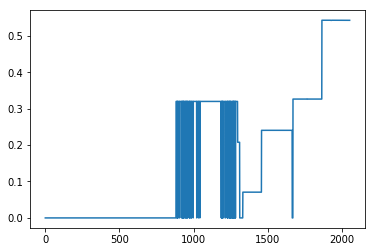

In [10]:
sns.lineplot(x=range(data0406.shape[1]),y=data0406[2222])

In [13]:
decoded = dae.predict(data0406[2222].reshape(1,data0406.shape[1],))

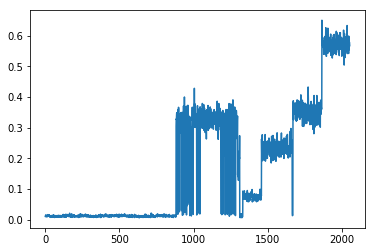

In [15]:
sns.lineplot(x=range(data0406.shape[1]),y=decoded[0])

In [20]:
basic_ae, basic_encoder = basic_ae(data0406, hidden_size=1500)

Epoch 1/2000
9636/9636 [==============================] - 2s 183us/step - loss: 0.0709 - acc: 0.0031
Epoch 2/2000
9636/9636 [==============================] - 1s 144us/step - loss: 0.0549 - acc: 0.0161
Epoch 3/2000
9636/9636 [==============================] - 1s 144us/step - loss: 0.0515 - acc: 0.0165
Epoch 4/2000
9636/9636 [==============================] - 1s 144us/step - loss: 0.0500 - acc: 0.0370
Epoch 5/2000
9636/9636 [==============================] - 1s 143us/step - loss: 0.0495 - acc: 0.0626
Epoch 6/2000
9636/9636 [==============================] - 1s 143us/step - loss: 0.0496 - acc: 0.0680
Epoch 7/2000
9636/9636 [==============================] - 1s 143us/step - loss: 0.0493 - acc: 0.0764
Epoch 8/2000
9636/9636 [==============================] - 1s 144us/step - loss: 0.0490 - acc: 0.0752
Epoch 9/2000
9636/9636 [==============================] - 1s 143us/step - loss: 0.0490 - acc: 0.0719
Epoch 10/2000
9636/9636 [==============================] - 1s 142us/step - loss: 0.0489 - a

9636/9636 [==============================] - 1s 148us/step - loss: 8.2415e-04 - acc: 0.1174
Epoch 157/2000
9636/9636 [==============================] - 1s 148us/step - loss: 5.3872e-04 - acc: 0.1231
Epoch 158/2000
9636/9636 [==============================] - 1s 147us/step - loss: 4.9174e-04 - acc: 0.1251
Epoch 159/2000
9636/9636 [==============================] - 1s 148us/step - loss: 4.8878e-04 - acc: 0.1205
Epoch 160/2000
9636/9636 [==============================] - 1s 148us/step - loss: 4.7759e-04 - acc: 0.1246
Epoch 161/2000
9636/9636 [==============================] - 1s 147us/step - loss: 5.2412e-04 - acc: 0.1238
Epoch 162/2000
9636/9636 [==============================] - 1s 148us/step - loss: 5.0404e-04 - acc: 0.1238
Epoch 163/2000
9636/9636 [==============================] - 1s 148us/step - loss: 6.7574e-04 - acc: 0.1200
Epoch 164/2000
9636/9636 [==============================] - 1s 148us/step - loss: 6.3718e-04 - acc: 0.1194
Epoch 165/2000
9636/9636 [==========================

9636/9636 [==============================] - 1s 146us/step - loss: 3.6015e-04 - acc: 0.1365
Epoch 309/2000
9636/9636 [==============================] - 1s 147us/step - loss: 3.5319e-04 - acc: 0.1388
Epoch 310/2000
9636/9636 [==============================] - 1s 147us/step - loss: 3.5580e-04 - acc: 0.1369
Epoch 311/2000
9636/9636 [==============================] - 1s 146us/step - loss: 3.4266e-04 - acc: 0.1356
Epoch 312/2000
9636/9636 [==============================] - 1s 146us/step - loss: 4.3077e-04 - acc: 0.1335
Epoch 313/2000
9636/9636 [==============================] - 1s 146us/step - loss: 3.5873e-04 - acc: 0.1368
Epoch 314/2000
9636/9636 [==============================] - 1s 147us/step - loss: 3.5088e-04 - acc: 0.1343
Epoch 315/2000
9636/9636 [==============================] - 1s 147us/step - loss: 3.6992e-04 - acc: 0.1342
Epoch 316/2000
9636/9636 [==============================] - 1s 146us/step - loss: 4.9628e-04 - acc: 0.1340
Epoch 317/2000
9636/9636 [==========================

9636/9636 [==============================] - 1s 147us/step - loss: 3.1218e-04 - acc: 0.1405
Epoch 461/2000
9636/9636 [==============================] - 1s 146us/step - loss: 3.4657e-04 - acc: 0.1380
Epoch 462/2000
9636/9636 [==============================] - 1s 147us/step - loss: 2.9624e-04 - acc: 0.1404
Epoch 463/2000
9636/9636 [==============================] - 1s 147us/step - loss: 3.1122e-04 - acc: 0.1427
Epoch 464/2000
9636/9636 [==============================] - 1s 147us/step - loss: 3.1097e-04 - acc: 0.1417
Epoch 465/2000
9636/9636 [==============================] - 1s 147us/step - loss: 3.8159e-04 - acc: 0.1438
Epoch 466/2000
9636/9636 [==============================] - 1s 146us/step - loss: 3.1728e-04 - acc: 0.1405
Epoch 467/2000
9636/9636 [==============================] - 1s 145us/step - loss: 3.1172e-04 - acc: 0.1422
Epoch 00467: early stopping


In [21]:
basic_decoded = basic_ae.predict(data0406[2222].reshape(1,data0406.shape[1],))

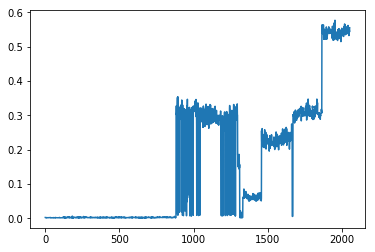

In [22]:
sns.lineplot(x=range(data0406.shape[1]),y=basic_decoded[0])

In [49]:
cae, cae_encoder = cae(data0406, hidden_size=1500)

Epoch 1/2000
9636/9636 [==============================] - 2s 199us/step - loss: 0.0596 - acc: 0.0063
Epoch 2/2000
9636/9636 [==============================] - 1s 145us/step - loss: 0.0271 - acc: 0.0221
Epoch 3/2000
9636/9636 [==============================] - 1s 145us/step - loss: 0.0146 - acc: 0.0310
Epoch 4/2000
9636/9636 [==============================] - 1s 145us/step - loss: 0.0092 - acc: 0.0389
Epoch 5/2000
9636/9636 [==============================] - 1s 144us/step - loss: 0.0069 - acc: 0.0456
Epoch 6/2000
9636/9636 [==============================] - 1s 145us/step - loss: 0.0053 - acc: 0.0540
Epoch 7/2000
9636/9636 [==============================] - 1s 145us/step - loss: 0.0042 - acc: 0.0605
Epoch 8/2000
9636/9636 [==============================] - 1s 144us/step - loss: 0.0038 - acc: 0.0664
Epoch 9/2000
9636/9636 [==============================] - 1s 145us/step - loss: 0.0038 - acc: 0.0688
Epoch 10/2000
9636/9636 [==============================] - 1s 145us/step - loss: 0.0038 - a

Epoch 159/2000
9636/9636 [==============================] - 1s 147us/step - loss: 7.8069e-04 - acc: 0.1242
Epoch 160/2000
9636/9636 [==============================] - 1s 147us/step - loss: 9.8665e-04 - acc: 0.1153
Epoch 161/2000
9636/9636 [==============================] - 1s 148us/step - loss: 9.6222e-04 - acc: 0.1159
Epoch 162/2000
9636/9636 [==============================] - 1s 147us/step - loss: 8.6704e-04 - acc: 0.1131
Epoch 163/2000
9636/9636 [==============================] - 1s 147us/step - loss: 8.6649e-04 - acc: 0.1205
Epoch 164/2000
9636/9636 [==============================] - 1s 147us/step - loss: 9.6940e-04 - acc: 0.1130
Epoch 165/2000
9636/9636 [==============================] - 1s 146us/step - loss: 0.0010 - acc: 0.1160
Epoch 166/2000
9636/9636 [==============================] - 1s 147us/step - loss: 8.0765e-04 - acc: 0.1202
Epoch 167/2000
9636/9636 [==============================] - 1s 146us/step - loss: 7.7192e-04 - acc: 0.1203
Epoch 168/2000
9636/9636 [===============

9636/9636 [==============================] - 1s 149us/step - loss: 7.0756e-04 - acc: 0.1304
Epoch 312/2000
9636/9636 [==============================] - 1s 148us/step - loss: 6.9201e-04 - acc: 0.1312
Epoch 313/2000
9636/9636 [==============================] - 1s 149us/step - loss: 7.1899e-04 - acc: 0.1255
Epoch 314/2000
9636/9636 [==============================] - 1s 149us/step - loss: 8.1261e-04 - acc: 0.1205
Epoch 315/2000
9636/9636 [==============================] - 1s 149us/step - loss: 6.7689e-04 - acc: 0.1283
Epoch 316/2000
9636/9636 [==============================] - 1s 149us/step - loss: 6.6212e-04 - acc: 0.1296
Epoch 317/2000
9636/9636 [==============================] - 1s 149us/step - loss: 6.5997e-04 - acc: 0.1300
Epoch 00317: early stopping


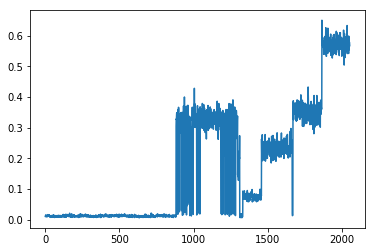

In [35]:
cae_decode = cae.predict(data0406[2222].reshape(1,data0406.shape[1],))
sns.lineplot(x=range(data0406.shape[1]),y=cae_decode[0])

In [45]:
cae1, cae_encoder1 = cae(data0406, hidden_size=1500, lam=1e-4)

Epoch 1/2000
9636/9636 [==============================] - 2s 192us/step - loss: 0.0647 - acc: 0.0033
Epoch 2/2000
9636/9636 [==============================] - 1s 145us/step - loss: 0.0282 - acc: 0.0117
Epoch 3/2000
9636/9636 [==============================] - 1s 144us/step - loss: 0.0180 - acc: 0.0274
Epoch 4/2000
9636/9636 [==============================] - 1s 144us/step - loss: 0.0116 - acc: 0.0300
Epoch 5/2000
9636/9636 [==============================] - 1s 143us/step - loss: 0.0083 - acc: 0.0454
Epoch 6/2000
9636/9636 [==============================] - 1s 143us/step - loss: 0.0076 - acc: 0.0567
Epoch 7/2000
9636/9636 [==============================] - 1s 143us/step - loss: 0.0067 - acc: 0.0622
Epoch 8/2000
9636/9636 [==============================] - 1s 143us/step - loss: 0.0061 - acc: 0.0724
Epoch 9/2000
9636/9636 [==============================] - 1s 143us/step - loss: 0.0056 - acc: 0.0749
Epoch 10/2000
9636/9636 [==============================] - 1s 145us/step - loss: 0.0052 - a

9636/9636 [==============================] - 1s 147us/step - loss: 0.0020 - acc: 0.0994
Epoch 161/2000
9636/9636 [==============================] - 1s 148us/step - loss: 0.0017 - acc: 0.1049
Epoch 162/2000
9636/9636 [==============================] - 1s 147us/step - loss: 0.0017 - acc: 0.1047
Epoch 163/2000
9636/9636 [==============================] - 1s 147us/step - loss: 0.0018 - acc: 0.1047
Epoch 164/2000
9636/9636 [==============================] - 1s 147us/step - loss: 0.0020 - acc: 0.1027
Epoch 165/2000
9636/9636 [==============================] - 1s 148us/step - loss: 0.0022 - acc: 0.1045
Epoch 166/2000
9636/9636 [==============================] - 1s 148us/step - loss: 0.0018 - acc: 0.1066
Epoch 167/2000
9636/9636 [==============================] - 1s 147us/step - loss: 0.0017 - acc: 0.1067
Epoch 168/2000
9636/9636 [==============================] - 1s 148us/step - loss: 0.0017 - acc: 0.1069
Epoch 169/2000
9636/9636 [==============================] - 1s 148us/step - loss: 0.0018

9636/9636 [==============================] - 1s 148us/step - loss: 0.0016 - acc: 0.1101
Epoch 319/2000
9636/9636 [==============================] - 1s 148us/step - loss: 0.0016 - acc: 0.1136
Epoch 320/2000
9636/9636 [==============================] - 1s 148us/step - loss: 0.0015 - acc: 0.1110
Epoch 321/2000
9636/9636 [==============================] - 1s 147us/step - loss: 0.0015 - acc: 0.1087
Epoch 322/2000
9636/9636 [==============================] - 1s 147us/step - loss: 0.0015 - acc: 0.1109
Epoch 323/2000
9636/9636 [==============================] - 1s 147us/step - loss: 0.0015 - acc: 0.1153
Epoch 324/2000
9636/9636 [==============================] - 1s 148us/step - loss: 0.0015 - acc: 0.1090
Epoch 325/2000
9636/9636 [==============================] - 1s 148us/step - loss: 0.0015 - acc: 0.1118
Epoch 326/2000
9636/9636 [==============================] - 1s 148us/step - loss: 0.0017 - acc: 0.1115
Epoch 327/2000
9636/9636 [==============================] - 1s 147us/step - loss: 0.0018

9636/9636 [==============================] - 1s 146us/step - loss: 0.0016 - acc: 0.1106
Epoch 477/2000
9636/9636 [==============================] - 1s 146us/step - loss: 0.0014 - acc: 0.1074
Epoch 478/2000
9636/9636 [==============================] - 1s 146us/step - loss: 0.0017 - acc: 0.1050
Epoch 479/2000
9636/9636 [==============================] - 1s 146us/step - loss: 0.0016 - acc: 0.1081
Epoch 480/2000
9636/9636 [==============================] - 1s 146us/step - loss: 0.0015 - acc: 0.1095
Epoch 481/2000
9636/9636 [==============================] - 1s 146us/step - loss: 0.0015 - acc: 0.1089
Epoch 482/2000
9636/9636 [==============================] - 1s 146us/step - loss: 0.0015 - acc: 0.1146
Epoch 483/2000
9636/9636 [==============================] - 1s 146us/step - loss: 0.0015 - acc: 0.1111
Epoch 484/2000
9636/9636 [==============================] - 1s 146us/step - loss: 0.0016 - acc: 0.1095
Epoch 485/2000
9636/9636 [==============================] - 1s 146us/step - loss: 0.0014

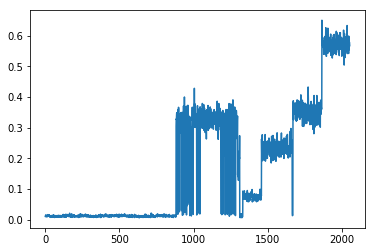

In [46]:
cae_decoded1 = cae1.predict(data0406[2222].reshape(1,data0406.shape[1],))
sns.lineplot(x=range(data0406.shape[1]),y=cae_decoded1[0])

In [47]:
cae2, cae_encoder2 = cae(data0406, hidden_size=1500, lam=1e-6)

Epoch 1/2000
9636/9636 [==============================] - 2s 195us/step - loss: 0.0620 - acc: 0.0076
Epoch 2/2000
9636/9636 [==============================] - 1s 144us/step - loss: 0.0275 - acc: 0.0157
Epoch 3/2000
9636/9636 [==============================] - 1s 144us/step - loss: 0.0149 - acc: 0.0298
Epoch 4/2000
9636/9636 [==============================] - 1s 144us/step - loss: 0.0082 - acc: 0.0554
Epoch 5/2000
9636/9636 [==============================] - 1s 144us/step - loss: 0.0063 - acc: 0.0643
Epoch 6/2000
9636/9636 [==============================] - 1s 142us/step - loss: 0.0048 - acc: 0.0777
Epoch 7/2000
9636/9636 [==============================] - 1s 142us/step - loss: 0.0040 - acc: 0.0802
Epoch 8/2000
9636/9636 [==============================] - 1s 142us/step - loss: 0.0037 - acc: 0.0759
Epoch 9/2000
9636/9636 [==============================] - 1s 142us/step - loss: 0.0034 - acc: 0.0751
Epoch 10/2000
9636/9636 [==============================] - 1s 142us/step - loss: 0.0033 - a

Epoch 157/2000
9636/9636 [==============================] - 1s 148us/step - loss: 5.3792e-04 - acc: 0.1284
Epoch 158/2000
9636/9636 [==============================] - 1s 148us/step - loss: 5.1495e-04 - acc: 0.1243
Epoch 159/2000
9636/9636 [==============================] - 1s 148us/step - loss: 5.4153e-04 - acc: 0.1282
Epoch 160/2000
9636/9636 [==============================] - 1s 148us/step - loss: 5.5511e-04 - acc: 0.1283
Epoch 161/2000
9636/9636 [==============================] - 1s 148us/step - loss: 5.4880e-04 - acc: 0.1221
Epoch 162/2000
9636/9636 [==============================] - 1s 148us/step - loss: 9.0705e-04 - acc: 0.1251
Epoch 163/2000
9636/9636 [==============================] - 1s 148us/step - loss: 6.4231e-04 - acc: 0.1216
Epoch 164/2000
9636/9636 [==============================] - 1s 148us/step - loss: 5.1486e-04 - acc: 0.1308
Epoch 165/2000
9636/9636 [==============================] - 1s 148us/step - loss: 6.0874e-04 - acc: 0.1248
Epoch 166/2000
9636/9636 [===========

9636/9636 [==============================] - 1s 146us/step - loss: 4.0486e-04 - acc: 0.1313
Epoch 310/2000
9636/9636 [==============================] - 1s 146us/step - loss: 4.6229e-04 - acc: 0.1297
Epoch 311/2000
9636/9636 [==============================] - 1s 147us/step - loss: 4.5395e-04 - acc: 0.1337
Epoch 312/2000
9636/9636 [==============================] - 1s 146us/step - loss: 4.1227e-04 - acc: 0.1361
Epoch 313/2000
9636/9636 [==============================] - 1s 146us/step - loss: 5.3619e-04 - acc: 0.1313
Epoch 314/2000
9636/9636 [==============================] - 1s 146us/step - loss: 4.4577e-04 - acc: 0.1310
Epoch 315/2000
9636/9636 [==============================] - 1s 147us/step - loss: 4.1662e-04 - acc: 0.1344
Epoch 316/2000
9636/9636 [==============================] - 1s 147us/step - loss: 4.3884e-04 - acc: 0.1342
Epoch 317/2000
9636/9636 [==============================] - 1s 147us/step - loss: 4.2983e-04 - acc: 0.1365
Epoch 318/2000
9636/9636 [==========================

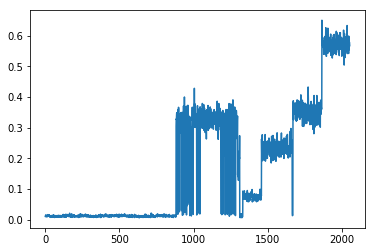

In [48]:
cae_decoded2 = cae2.predict(data0406[2222].reshape(1,data0406.shape[1],))
sns.lineplot(x=range(data0406.shape[1]),y=cae_decoded2[0])

In [52]:
cae3, cae_encoder3 = cae(data0406, hidden_size=1500, lam=1e-7)

Epoch 1/2000
9636/9636 [==============================] - 2s 203us/step - loss: 0.0684 - acc: 0.0081
Epoch 2/2000
9636/9636 [==============================] - 1s 147us/step - loss: 0.0359 - acc: 0.0213
Epoch 3/2000
9636/9636 [==============================] - 1s 146us/step - loss: 0.0148 - acc: 0.0229
Epoch 4/2000
9636/9636 [==============================] - 1s 145us/step - loss: 0.0074 - acc: 0.0349
Epoch 5/2000
9636/9636 [==============================] - 1s 144us/step - loss: 0.0056 - acc: 0.0435
Epoch 6/2000
9636/9636 [==============================] - 1s 142us/step - loss: 0.0051 - acc: 0.0581
Epoch 7/2000
9636/9636 [==============================] - 1s 143us/step - loss: 0.0041 - acc: 0.0636
Epoch 8/2000
9636/9636 [==============================] - 1s 143us/step - loss: 0.0035 - acc: 0.0637
Epoch 9/2000
9636/9636 [==============================] - 1s 143us/step - loss: 0.0032 - acc: 0.0718
Epoch 10/2000
9636/9636 [==============================] - 1s 143us/step - loss: 0.0030 - a

Epoch 157/2000
9636/9636 [==============================] - 1s 144us/step - loss: 5.9307e-04 - acc: 0.1273
Epoch 158/2000
9636/9636 [==============================] - 1s 143us/step - loss: 5.5963e-04 - acc: 0.1280
Epoch 159/2000
9636/9636 [==============================] - 1s 144us/step - loss: 6.0448e-04 - acc: 0.1259
Epoch 160/2000
9636/9636 [==============================] - 1s 144us/step - loss: 5.4768e-04 - acc: 0.1267
Epoch 161/2000
9636/9636 [==============================] - 1s 145us/step - loss: 4.8098e-04 - acc: 0.1272
Epoch 162/2000
9636/9636 [==============================] - 1s 144us/step - loss: 5.4074e-04 - acc: 0.1274
Epoch 163/2000
9636/9636 [==============================] - 1s 144us/step - loss: 4.9363e-04 - acc: 0.1301
Epoch 164/2000
9636/9636 [==============================] - 1s 144us/step - loss: 5.3983e-04 - acc: 0.1300
Epoch 165/2000
9636/9636 [==============================] - 1s 144us/step - loss: 4.7636e-04 - acc: 0.1325
Epoch 166/2000
9636/9636 [===========

9636/9636 [==============================] - 1s 148us/step - loss: 3.7197e-04 - acc: 0.1354
Epoch 310/2000
9636/9636 [==============================] - 1s 149us/step - loss: 5.7386e-04 - acc: 0.1371
Epoch 311/2000
9636/9636 [==============================] - 1s 148us/step - loss: 3.7301e-04 - acc: 0.1397
Epoch 312/2000
9636/9636 [==============================] - 1s 149us/step - loss: 4.3020e-04 - acc: 0.1377
Epoch 313/2000
9636/9636 [==============================] - 1s 148us/step - loss: 3.8616e-04 - acc: 0.1383
Epoch 314/2000
9636/9636 [==============================] - 1s 149us/step - loss: 4.1706e-04 - acc: 0.1361
Epoch 315/2000
9636/9636 [==============================] - 1s 148us/step - loss: 3.9730e-04 - acc: 0.1390
Epoch 316/2000
9636/9636 [==============================] - 1s 148us/step - loss: 3.8229e-04 - acc: 0.1370
Epoch 317/2000
9636/9636 [==============================] - 1s 148us/step - loss: 3.6199e-04 - acc: 0.1401
Epoch 318/2000
9636/9636 [==========================

9636/9636 [==============================] - 1s 146us/step - loss: 3.3043e-04 - acc: 0.1450
Epoch 462/2000
9636/9636 [==============================] - 1s 146us/step - loss: 3.2006e-04 - acc: 0.1440
Epoch 463/2000
9636/9636 [==============================] - 1s 146us/step - loss: 3.3055e-04 - acc: 0.1427
Epoch 464/2000
9636/9636 [==============================] - 1s 146us/step - loss: 2.9469e-04 - acc: 0.1500
Epoch 465/2000
9636/9636 [==============================] - 1s 146us/step - loss: 3.0221e-04 - acc: 0.1480
Epoch 466/2000
9636/9636 [==============================] - 1s 146us/step - loss: 3.1537e-04 - acc: 0.1451
Epoch 467/2000
9636/9636 [==============================] - 1s 146us/step - loss: 3.2913e-04 - acc: 0.1452
Epoch 468/2000
9636/9636 [==============================] - 1s 146us/step - loss: 3.3670e-04 - acc: 0.1425
Epoch 469/2000
9636/9636 [==============================] - 1s 147us/step - loss: 3.5999e-04 - acc: 0.1474
Epoch 470/2000
9636/9636 [==========================

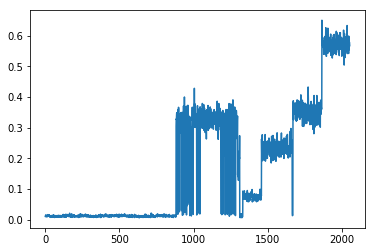

In [53]:
cae_decoded3 = cae3.predict(data0406[2222].reshape(1,data0406.shape[1],))
sns.lineplot(x=range(data0406.shape[1]),y=cae_decoded3[0])